Remember to change the runtime hardware accelerator to GPU

In [1]:
import numpy as np
import os
import random
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf

## Helper functions

In [2]:
def seed_everything(seed):
  os.environ['PYTHONHASHSEED']=str(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
seed_everything(666)

In [3]:
# !pip install git+https://github.com/qubvel/classification_models.git
!pip install -U git+https://github.com/qubvel/efficientnet
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-1as5n3qw
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-1as5n3qw
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18421 sha256=6a7847df309c8a2578807355e91dd9df81b622990400f3deb7d9144a78bacc0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-fgl_jcj8/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-0q_kyxev
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-0q_kyxev
  Created wheel for albumentations: filename=albumentations-0.5.0-cp36-none-any.whl size=70569 sha256=a2e902dd5afbb3fbd0ee357aff92bab759bfc9df5a69febdb87845

In [4]:
# from classification_models.keras import Classifiers
import efficientnet.keras as efn 
from albumentations import (
    Compose, RandomBrightnessContrast, OneOf, ShiftScaleRotate, HueSaturationValue, 
    HorizontalFlip, ToGray, Resize, GaussNoise)

In [5]:
dataset_url ="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='images', 
                                   untar=True,
                                   cache_dir='/content/')

pathlib.Path('/content/datasets/images.tar.gz').unlink() 

791920640/791918971 [==============================] - 22s 0us/step


In [6]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
TRN_SIZE = 5000
NUM_EPOCH = 10
data_dir = pathlib.Path(data_dir)
images_list = data_dir.glob('*.jpg')
images_list = [str(x) for x in images_list]
np.random.shuffle(images_list)
def get_label_from_path(path):
  label = '_'.join(path.split(os.sep)[-1].split('_')[:-1]).lower()
  return label
labels_list = [get_label_from_path(x) for x in images_list]
labels = list(set(labels_list))
labels_to_num = dict(zip(labels, range(len(labels))))
labels_list = [labels_to_num[x] for x in labels_list]
all_data = tf.data.Dataset.from_tensor_slices((images_list, labels_list))
data_train = all_data.take(TRN_SIZE) 
data_val = all_data.skip(TRN_SIZE)

In [7]:
transforms_train = Compose([
            Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
            GaussNoise(p=0.1),
            OneOf([RandomBrightnessContrast(), HueSaturationValue()], p=0.7),
            HorizontalFlip(p=0.5),
            ToGray(p=0.2),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5)
        ])

transforms_val = Compose([
            Resize(IMG_SIZE[0], IMG_SIZE[1], p=1)
        ])

def aug_fn(image, train):
    data = {"image": image}
    if train:
      data = transforms_train(**data)
    else:
      data = transforms_val(**data)
    aug_img = data["image"]
    aug_img = efn.preprocess_input(aug_img) # Don't forget the preprocess function!
    return aug_img

def parse(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    label = tf.one_hot(label, 37)
    return image, label

def process_data_train(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, True], 
                                Tout=tf.float32)
    return aug_img, label

def process_data_val(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, False], 
                                Tout=tf.float32)
    return aug_img, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

data_train = data_train.shuffle(buffer_size=BATCH_SIZE*4).map(parse, 
                  num_parallel_calls=AUTOTUNE).map(process_data_train,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
data_val = data_val.shuffle(buffer_size=BATCH_SIZE*4).map(parse, 
                  num_parallel_calls=AUTOTUNE).map(process_data_val,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

## Define Model

# Model with frozen layers

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(37)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## LR Finder
https://github.com/surmenok/keras_lr_finder

In [10]:
!pip install -U git+https://github.com/surmenok/keras_lr_finder

  Cloning https://github.com/surmenok/keras_lr_finder to /tmp/pip-req-build-q1ygwo0l
  Running command git clone -q https://github.com/surmenok/keras_lr_finder /tmp/pip-req-build-q1ygwo0l
  Created wheel for keras-lr-finder: filename=keras_lr_finder-0.1-cp36-none-any.whl size=4002 sha256=b0185d8acc825e02aeaf191b8eff4cbde2ca4d8fd127d2756fac2ced394c290c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vn_ibjo7/wheels/6c/bc/50/d263cf575b9ec800b46c945458f9586805001954a7fe6a2a21
Successfully built keras-lr-finder
  Found existing installation: keras-lr-finder 0.1
    Uninstalling keras-lr-finder-0.1:
      Successfully uninstalled keras-lr-finder-0.1


In [11]:
from keras_lr_finder import LRFinder

In [12]:
lr_finder = LRFinder(model)
lr_finder.find_generator(data_train, start_lr=1e-8, end_lr=1, epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
157/157 [==============================] - 17s 108ms/step - loss: 3.7663 - accuracy: 0.0234
Epoch 2/5
157/157 [==============================] - 17s 110ms/step - loss: 3.7586 - accuracy: 0.0266
Epoch 3/5
157/157 [==============================] - 17s 109ms/step - loss: 3.3607 - accuracy: 0.1380
Epoch 4/5
157/157 [==============================] - 17s 110ms/step - loss: 1.0387 - accuracy: 0.7520
Epoch 5/5
157/157 [==============================] - 18s 112ms/step - loss: 5.6268 - accuracy: 0.6942


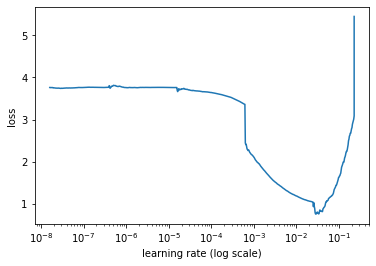

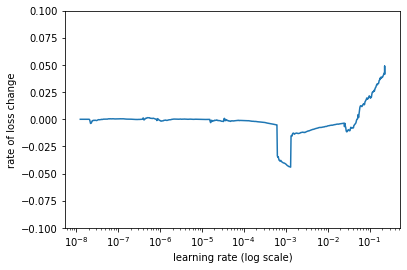

0.001305941

In [13]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
lr_finder.plot_loss_change(sma=BATCH_SIZE, y_lim=(-0.1,0.1))
lr_finder.get_best_lr(BATCH_SIZE)


In [14]:
MAX_LR = 1e-3

## OneCycle LR Scheduler
https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/?fbclid=IwAR2vo93ZAFIyY9BKL1t5SQhX6vH-_qfOtzCqaq0NYJTa7PWS7YoPtRqktDY

Let's import manually the scheduler. We also modified the ```OneCycleScheduler``` class so that it works also with Adam optimizer , which has ```beta_1``` variable instead of ```momentum``` (see ```set_momentum()``` and ```get_momentum()``` functions).

### Manual import

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            if hasattr(self.model.optimizer, 'momentum'):
              return tf.keras.backend.get_value(self.model.optimizer.momentum)
            elif hasattr(self.model.optimizer, 'beta_1'):
              return tf.keras.backend.get_value(self.model.optimizer.beta_1)
            else:
              return None
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            if hasattr(self.model.optimizer, 'momentum'):
              tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
            elif hasattr(self.model.optimizer, 'beta_1'):
              tf.keras.backend.set_value(self.model.optimizer.beta_1, mom)
            else:
              pass
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [16]:
steps = np.ceil(TRN_SIZE / BATCH_SIZE) * NUM_EPOCH
lr_schedule = OneCycleScheduler(MAX_LR, steps)

## Training

In [17]:
model.fit(x=data_train, validation_data=data_val, epochs=NUM_EPOCH, callbacks=[lr_schedule])

Epoch 1/10
157/157 [==============================] - 24s 152ms/step - loss: 3.3632 - accuracy: 0.1370 - val_loss: 2.4639 - val_accuracy: 0.5481
Epoch 2/10
157/157 [==============================] - 23s 150ms/step - loss: 1.6081 - accuracy: 0.6880 - val_loss: 0.8060 - val_accuracy: 0.8611
Epoch 3/10
157/157 [==============================] - 24s 151ms/step - loss: 0.7290 - accuracy: 0.8204 - val_loss: 0.4817 - val_accuracy: 0.8854
Epoch 4/10
157/157 [==============================] - 24s 151ms/step - loss: 0.5375 - accuracy: 0.8512 - val_loss: 0.3987 - val_accuracy: 0.8967
Epoch 5/10
157/157 [==============================] - 25s 157ms/step - loss: 0.4522 - accuracy: 0.8702 - val_loss: 0.3634 - val_accuracy: 0.8958
Epoch 6/10
157/157 [==============================] - 24s 154ms/step - loss: 0.4110 - accuracy: 0.8846 - val_loss: 0.3463 - val_accuracy: 0.9017
Epoch 7/10
157/157 [==============================] - 24s 155ms/step - loss: 0.3753 - accuracy: 0.8974 - val_loss: 0.3367 - val_ac

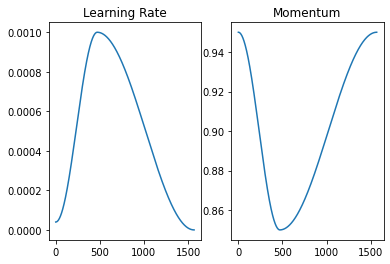

In [18]:
lr_schedule.plot()

# Model without frozen layers
Do the same procedure without any frozen layer

In [19]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Set LR scheduler

Epoch 1/5
157/157 [==============================] - 27s 174ms/step - loss: 0.3410 - accuracy: 0.9056
Epoch 2/5
157/157 [==============================] - 27s 173ms/step - loss: 0.3263 - accuracy: 0.9046
Epoch 3/5
157/157 [==============================] - 27s 175ms/step - loss: 0.3840 - accuracy: 0.8728
Epoch 4/5
157/157 [==============================] - 28s 176ms/step - loss: 0.8848 - accuracy: 0.7172


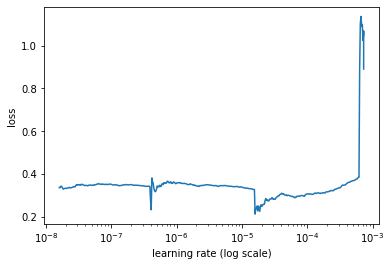

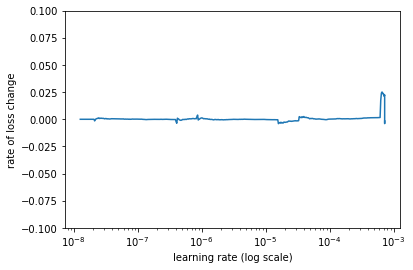

1.5848933e-05

In [20]:
lr_finder = LRFinder(model)
lr_finder.find_generator(data_train, start_lr=1e-8, end_lr=1, epochs=5)
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
lr_finder.plot_loss_change(sma=BATCH_SIZE, y_lim=(-0.1,0.1))
lr_finder.get_best_lr(BATCH_SIZE)

In [21]:
MAX_LR = 1.5e-5
steps = np.ceil(TRN_SIZE / BATCH_SIZE) * NUM_EPOCH
lr_schedule = OneCycleScheduler(MAX_LR, steps)

## Training

In [22]:
model.fit(x=data_train, validation_data=data_val, epochs=NUM_EPOCH, callbacks=[lr_schedule])

Epoch 1/10
157/157 [==============================] - 34s 218ms/step - loss: 0.3365 - accuracy: 0.9016 - val_loss: 0.3166 - val_accuracy: 0.9063
Epoch 2/10
157/157 [==============================] - 34s 214ms/step - loss: 0.2928 - accuracy: 0.9120 - val_loss: 0.2994 - val_accuracy: 0.9075
Epoch 3/10
157/157 [==============================] - 33s 213ms/step - loss: 0.2675 - accuracy: 0.9110 - val_loss: 0.2894 - val_accuracy: 0.9075
Epoch 4/10
157/157 [==============================] - 34s 213ms/step - loss: 0.2448 - accuracy: 0.9178 - val_loss: 0.2823 - val_accuracy: 0.9092
Epoch 5/10
157/157 [==============================] - 34s 214ms/step - loss: 0.2290 - accuracy: 0.9224 - val_loss: 0.2800 - val_accuracy: 0.9105
Epoch 6/10
157/157 [==============================] - 34s 215ms/step - loss: 0.2163 - accuracy: 0.9262 - val_loss: 0.2759 - val_accuracy: 0.9138
Epoch 7/10
157/157 [==============================] - 33s 211ms/step - loss: 0.1981 - accuracy: 0.9332 - val_loss: 0.2743 - val_ac

Seems like there is no need to unfreezing the model layer by layer and we improved a bit on validation set. That can be potentially be improved further by using more augmentations, try for yourself! (just add more augmentation functions into ```transforms_train```, you have to import them from albumentations, see official documentation https://albumentations.ai/docs/api_reference/augmentations/transforms/)

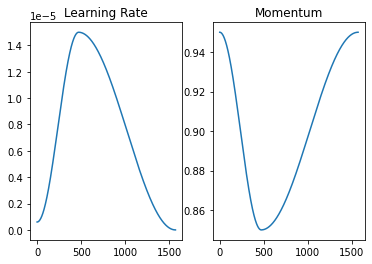

In [23]:
lr_schedule.plot()